In [ ]:
# Do all imports
import networkx as nx
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
import sklearn.metrics
from sklearn.metrics import silhouette_score

import pandas as pd
import networkx as nx
import networkx.algorithms.community as nx_comm
import networkx.algorithms.flow as nx_flow
import networkx.algorithms.shortest_paths as nx_path

import numpy as np
import scipy as sp

import collections
import itertools
import math

import os

# some basic settings for plotting figures
import matplotlib.pyplot as plt


In [2]:
import warnings
warnings.simplefilter('ignore')

# Download raw data

In [3]:
# Download all raw data files
if not os.path.exists('4932.protein.links.detailed.v11.5.txt'):
    !curl -O https://raw.githubusercontent.com/jqxcz/MATH3888/master/4932.protein.links.detailed.v11.5.txt
    !curl -O https://raw.githubusercontent.com/jqxcz/MATH3888/master/4932.protein.info.v11.5.txt
    !curl -O https://raw.githubusercontent.com/jqxcz/MATH3888/master/uniprot.tsv
    !curl -O https://raw.githubusercontent.com/jqxcz/MATH3888/master/essential.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 90.0M  100 90.0M    0     0  5949k      0  0:00:15  0:00:15 --:--:-- 6272k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1900k  100 1900k    0     0  5556k      0 --:--:-- --:--:-- --:--:-- 5539k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1957k  100 1957k    0     0  5642k      0 --:--:-- --:--:-- --:--:-- 5642k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 95667  100 95667    0     0  1698k      0 --:--:-- --:--:-- --:--:-- 1730k


# Preprocessing uniprot data

In [4]:
df = pd.read_table('uniprot.tsv',delimiter='\t')

## Create columns that match for subcellular location

We search the column `'Subcellular location [CC]'` for a substring match for each of the locations:

 - Mitochondrial protein
 - Cytoplasm protein
 - Membrane protein
 - Nucleus protein
 - Ribosomal protein

In [5]:
attributes = ['mitochon', 'cytoplasm', 'membrane', 'nucleus']

for attr in attributes:
    df[attr] = df['Subcellular location [CC]'].str.contains(attr, case=False)

df['ribosomal'] = df['Protein names'].str.contains('ribosomal', case=False).fillna(False)
df['ribosomal'] |= df['Protein names'].str.contains('ribosome', case=False).fillna(False)


We drop the extra column

In [6]:
df = df.drop(columns='Subcellular location [CC]')

Now, we create a column to be the number of locations each protein is in.
 - Mitochondrial protein
 - Cytoplasm protein
 - Membrane protein
 - Nucleus protein

In [7]:
df['location_match'] = 0
for attr in attributes:
    df['location_match'] += df[attr]
df['location_match'] = df['location_match'].fillna(0)

Save dataframe as a csv file.

In [8]:
df.to_csv('uniprot_processed.csv')

# Main analysis

## Reading in and doing initial processing of data

In [9]:
# Generate common name for yeast proteins
temp_df = pd.read_table("4932.protein.info.v11.5.txt",delimiter='\t')
common_name = dict(temp_df.iloc[:,:2].values)

In [10]:
# Read in preprocessed uniprot data
uniprot_df = pd.read_csv('uniprot_processed.csv')

In [11]:
# Read in essential node data
essential_df = pd.read_csv('essential.csv', header=None)

Track studied proteins and their yeast name.

In [12]:
# Let's keep track of our studied proteins
studied_proteins = {
    'DIC1': '4932.YLR348C',
    'RGT2': '4932.YDL138W',
    'CBF5': '4932.YLR175W',
    'EST2': '4932.YLR318W'
}

In [13]:
# Read in dataframe for detailed protein links
G0_dataframe = pd.read_table("./4932.protein.links.detailed.v11.5.txt", delimiter=' ')

Reweight interactions. We:
- Double the weight of experimental evidence
- Halve the weight of textmining evidence

In [14]:
# Reweight edges of protein links
keep_columns = [
    'neighborhood', 'fusion', 'cooccurence', 
    'coexpression', 'experimental', 'database', 
    'textmining'
]

# Double weight of experimental evidence
G0_dataframe['experimental'] *= 2

# Half weight of textmining
G0_dataframe['textmining'] //=2

# Calculate combined score
G0_dataframe.combined_score = G0_dataframe[keep_columns].max(axis=1)

# Drop edges with combined score of zero
G0_dataframe = G0_dataframe.drop(G0_dataframe[G0_dataframe.combined_score == 0].index)

We remove all edges with combined score <= 600

In [15]:
# Drop edges with combined score of <= threshold score
threshold_score = 600
G0_dataframe = G0_dataframe.drop(
    G0_dataframe[G0_dataframe.combined_score <= threshold_score].index
    )

In [16]:
# Sanity check of data

# G0_dataframe

Now, we create our networkx graph

In [17]:
# Create nx graph

G0 = nx.from_pandas_edgelist(G0_dataframe, 
    source='protein1', 
    target='protein2', 
    edge_attr=True)

Now, we remove proteins that are not in cellular location of interest.

We also remove ribosomal proteins.

In [18]:
# Ignore certain nodes in the protein network, and also combine uniprot data

# remove proteins that are not in a location that we are targeting
# (we target membrane, mitochrondrial, cytoplasm and nucleus proteins)
irrelevant_proteins = []

# remove proteins that are ribosomal
ribosomal_proteins = []

row_index = {}

for node in G0.nodes:
    # Get row index of matching row for a protein
    node_name = node.split('.')[1]
    node_matches = uniprot_df['Gene Names'].str.contains(node_name).fillna(False)
    node_uniprot = uniprot_df.index[node_matches][0]

    if uniprot_df['location_match'][node_uniprot] == 0:
        irrelevant_proteins.append(node)

    elif uniprot_df['ribosomal'][node_uniprot] == True:
        ribosomal_proteins.append(node)

    else:
        row_index[node] = node_uniprot

print(f"{len(irrelevant_proteins)=}, {len(ribosomal_proteins)=}")
print(f"{len(G0.nodes)=}")
G0.remove_nodes_from(irrelevant_proteins)
G0.remove_nodes_from(ribosomal_proteins)
print(f"{len(G0.nodes)=}")

len(irrelevant_proteins)=1334, len(ribosomal_proteins)=312
len(G0.nodes)=5912
len(G0.nodes)=4266


We now remove essential proteins.

In [19]:
# We remove essential proteins, but keep proteins we want to study
essential_proteins_raw = essential_df[1].values
essential_proteins = set(map(lambda x: '4932.' + x, essential_proteins_raw))
essential_proteins -= set(studied_proteins.values())
print(f"{len(G0.nodes)=}")
G0.remove_nodes_from(list(essential_proteins))
print(f"{len(G0.nodes)=}")

len(G0.nodes)=4266
len(G0.nodes)=3271


We also remove proteins that are not in the largest connected component.

In [20]:
# Let's only keep the largest connected component
largest_component = max(list(nx.connected_components(G0)), key=len)
G0 = G0.subgraph(largest_component)
print(f"{len(G0.nodes)=}")

len(G0.nodes)=3172


In [21]:
# Sanity check - 
#   Check proteins we are interested in are still in the network

for key, value in studied_proteins.items():
    if value not in G0.nodes:
        print(f"ERROR: {key} was deleted from the network!")

We add the location of each protein into the node.

In [22]:
# Track location of nodes
node_location = {}

for node in G0.nodes:
    if uniprot_df['mitochon'][row_index[node]] == 1:
        node_location[node] = 'mitochondria'
    elif uniprot_df['cytoplasm'][row_index[node]] == 1:
        node_location[node] = 'cytoplasm'
    elif uniprot_df['membrane'][row_index[node]] == 1:
        node_location[node] = 'membrane'
    elif uniprot_df['nucleus'][row_index[node]] == 1:
        node_location[node] = 'nucleus'
    else:
        node_location[node] = 'other'

nx.set_node_attributes(G0, values=node_location, name='location')

We define the direction of interaction to be those we are interested in.

In [23]:
direction = {
    'mitochondria': {'cytoplasm', 'mitochondria'},
    'cytoplasm': {'nucleus', 'mitochondria', 'cytoplasm'},
    'nucleus': {'nucleus'},
    'membrane': {'mitochondria', 'membrane'}
}

Construct our directed graph.

In [24]:
GX = nx.DiGraph()
for edge in G0.edges:
    if G0.nodes[edge[1]]['location'] in direction[G0.nodes[edge[0]]['location']]:
        GX.add_edge(edge[0], edge[1])
    if G0.nodes[edge[0]]['location'] in direction[G0.nodes[edge[1]]['location']]:
        GX.add_edge(edge[1], edge[0])

Define our code for getting all paths between start and end.

We allow for the abiity to set a mininum threshold for the least frequent protein amongst all paths returned.

In [25]:
def get_paths(start, end, func, min_count=1, **kwargs):
    paths = list(func(GX, 
            studied_proteins[start], 
            studied_proteins[end], **kwargs))
    all_occurrences = collections.Counter(itertools.chain.from_iterable(paths))
    return (p for p in paths if min(set(map(all_occurrences.get, p))) > min_count)

In [26]:
def print_paths(start, end, func, reverse=False, **kwargs):
    out = lambda x: ', '.join(map(common_name.get, x))
    if reverse:
        out = lambda x: ', '.join(reversed(list(map(common_name.get, x))))
    print('\n'.join(sorted(map(out, get_paths(start, end, func, **kwargs)))))

In [27]:
for start in ['DIC1', 'RGT2']:
    for end in ['CBF5', 'EST2']:
        try:
            print(start, 'to', end)
            num = sum(1 for _ in get_paths(start, end, nx.all_simple_paths, min_count=1, cutoff=5))
            print(num)
            print(sum(1 for _ in get_paths(start, end, nx.all_simple_paths, 
                min_count=math.sqrt(num)/2-2, cutoff=5)))
        except Exception as e:
            print(e)


DIC1 to CBF5


KeyboardInterrupt: 

## Homotopic Clustering

In [ ]:
class HomotopyNet:
    
    def __init__(self, start, end, PPI, pathlength, lap=False):
        self.start = start
        self.end = end
        self.PPI = PPI
        self.pathlength = pathlength
        self.lap = lap
        
        paths = nx.algorithms.simple_paths.all_simple_paths(GX, 
            studied_proteins[start], 
            studied_proteins[end], cutoff=pathlength)
        #allpaths = [np.array(p) for p in paths]

        pathlist = list(get_paths(start, end, nx.all_simple_paths, 
                min_count=math.sqrt(num)/2-2, cutoff=pathlength))

        pathlist = list(nx.algorithms.simple_paths.all_simple_paths(GX, 
            studied_proteins[start], 
            studied_proteins[end], cutoff=pathlength))
        allpathsets = [set(zip(p[0:-1], p[1:])) for p in pathlist]
        
        self.pathlist = pathlist
        self.allpathsets = allpathsets
        self.size = len(pathlist)
        
        HomotopyG = nx.Graph()
        for i, P in enumerate(allpathsets):
            for j, Q in enumerate(allpathsets[i+1:], start = i+1):
                weight = len(P & Q) / len(P | Q)
                if weight > 0:
                    HomotopyG.add_edge(i,j, weight=weight)
                    
            
            if i % 100 == 0:
                print(i)
        print("finished network")
                    
        self.HomotopyG = HomotopyG
        if lap:
            print("construct Laplacian")
            self.lap = nx.laplacian_matrix(HomotopyG).astype(float)
            
        self.np_mat = nx.to_numpy_matrix(self.HomotopyG)
        
    def k_Elbow(self):
        if not self.lap:
            return "Error: Adj = FALSE"
        silhouette_coeffs = []
        K = range(2, 11)
        
        for k in K:
            w,v = sp.sparse.linalg.eigsh(self.L, k=k, which = 'SM')
            X = v*w
            kmeans = KMeans(init="k-means++", n_clusters=k, n_init=10)
            kmeans.fit_predict(X)
            #centroids = kmeans.cluster_centers_
            labels = kmeans.labels_
            #error = kmeans.inertia_
            score = silhouette_score(X, labels)
            silhouette_coeffs.append(score)
        #closest = sklearn.metrics.pairwise_distances_argmin(centroids, X)
        plt.plot(K, silhouette_coeffs)
        plt.xlabel("Number of Partitions")
        plt.ylabel("Silhouette Coefficients")
        
    def indices_to_pathname(self, indices):
        
        # Takes in a list of numbers and returns their paths
        
        path_ls = [self.pathlist[i] for i in indices]
        return path_ls
    
    def KMeans_cluster(self, k):
        
        # Defunct
        
        if not self.lap:
            return "Error: Adj = FALSE"
        w,v = sp.sparse.linalg.eigsh(self.L, k=k, which = 'SM')
        X = v*w
        kmeans = KMeans(init="k-means++", n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_
        error = kmeans.inertia_
        
        closest = sklearn.metrics.pairwise_distances_argmin(centroids, X)
        
        return closest, labels
    
    def plot(self, alpha, comms, label_true = False):
        
        # Plots HomotopyG with partition (comms) coloured.
        
        edges,weights = zip(*nx.get_edge_attributes(self.HomotopyG,'weight').items())
        
        colourmap = comms
        
        pos = nx.spring_layout(self.HomotopyG)
        nx.draw(self.HomotopyG, pos, node_color=colourmap, edgelist=edges, cmap=plt.cm.CMRmap, alpha = alpha,
                edge_color=tuple(map(np.log, weights)), 
                width=1, edge_cmap=plt.cm.binary, with_labels = label_true)
        plt.savefig(self.start + "-" + self.end + "_visual")
        
    def Spectral_Cluster(self, k):
        
        # Obtains k partition of the HomotopyG network using spectral clustering and returns the centroids + clusters
        
        clustering = SpectralClustering(k).fit(self.np_mat)
        clusters = clustering.fit_predict(self.np_mat, 2)
        
        centroids = []
        for j in range(k):
            subG = nx.induced_subgraph(self.HomotopyG, [i for i in self.HomotopyG.nodes if clusters[i] == j])
            dic = nx.eigenvector_centrality(subG)
            centroids.append(max(dic, key=dic.get))
        return centroids, clusters
    
    def Spectral_Modularity_Plot(self):
        
        # Plots modularity of spectral clusters for each integer k of clusters AND returns k with best modularity
        
        K = range(2, 11)
        levels = []
        
        for k in K:
            Spec = self.Spectral_Cluster(k)
            labs = Spec[1]
            clustersets = [set(np.where(labs == i)[0]) for i in range(0, k)]
            levels.append(clustersets)
        
        mods = [nx_comm.modularity(self.HomotopyG, levels[k-2]) for k in K]
        plt.plot(K, mods)
        plt.title(self.start + " -> " + self.end + " Modularity vs Partition number")
        plt.xlabel("Number of Partitions")
        plt.ylabel("Modularity")
        plt.savefig(self.start + "-" + self.end + "_modularity")
        
        return mods.index(max(mods)) + 2
            

In [ ]:
def path_to_proteins(path):
    
    # Takes in paths (sequence of node pairs) and returns the protein pathway.
    
    out = lambda x: ', '.join(map(common_name.get, x))
    
    print('\n'.join(sorted(map(out, path))))

## DIC1 -> EST2

In [ ]:
# Spectral + Modularity

In [ ]:
HomNet = HomotopyNet('DIC1', 'EST2', GX, 4)
HomNet.size

0
100
200
300
400
500
finished network


563

DIC1, ATP1, PUF3, HEK2, EST2
DIC1, ATP23, MGR1, HEK2, EST2
DIC1, PUF3, KIN1, ISW1, EST2
DIC1, PUF3, MRX9, HEK2, EST2
DIC1, PUF3, NAB6, ISW1, EST2
DIC1, PUF3, NAB6, MRN1, EST2


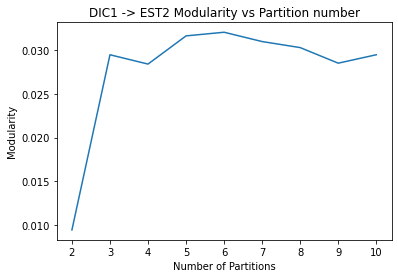

In [ ]:
k = HomNet.Spectral_Modularity_Plot()
Spec = HomNet.Spectral_Cluster(k)
path_to_proteins(HomNet.indices_to_pathname(Spec[0]))

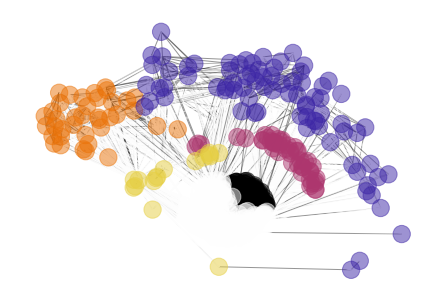

In [ ]:
HomNet.plot(0.5, Spec[1])

## DIC1 -> CBF5

In [ ]:
HomNet = HomotopyNet('DIC1', 'CBF5', GX, 4)
HomNet.size

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
finished network


2107

In [ ]:
k = HomNet.Spectral_Modularity_Plot()
Spec = HomNet.Spectral_Cluster(k)
path_to_proteins(HomNet.indices_to_pathname(Spec[0]))

KeyboardInterrupt: 

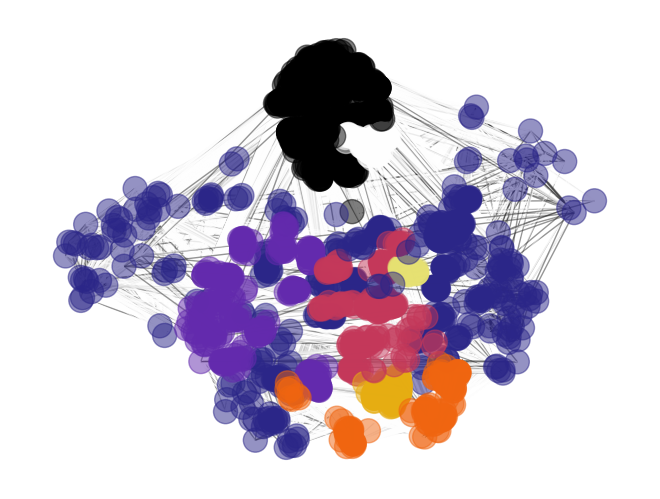

In [ ]:
HomNet.plot(0.5, Spec[1])

## RGT2 -> EST2

In [ ]:
HomNet = HomotopyNet('RGT2', 'EST2', GX, 5)
HomNet.size

0
finished network


22

/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


RGT2, BPT1, YOR1, PUF3, PUB1, EST2
RGT2, GPR1, RAS2, PHB1, TOR1, EST2
RGT2, SNF3, HXT3, PUF3, HEK2, EST2


/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


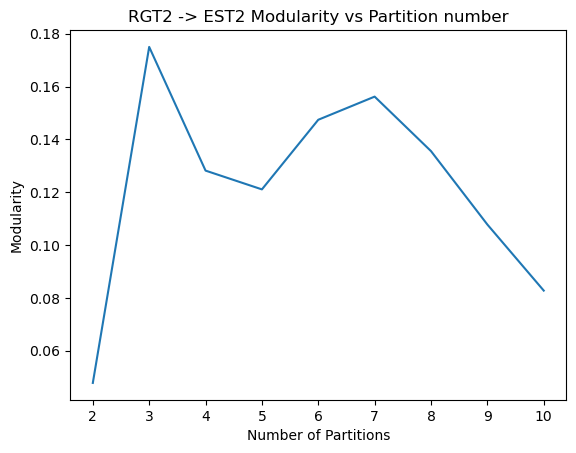

In [ ]:
k = HomNet.Spectral_Modularity_Plot()
Spec = HomNet.Spectral_Cluster(k)
path_to_proteins(HomNet.indices_to_pathname(Spec[0]))

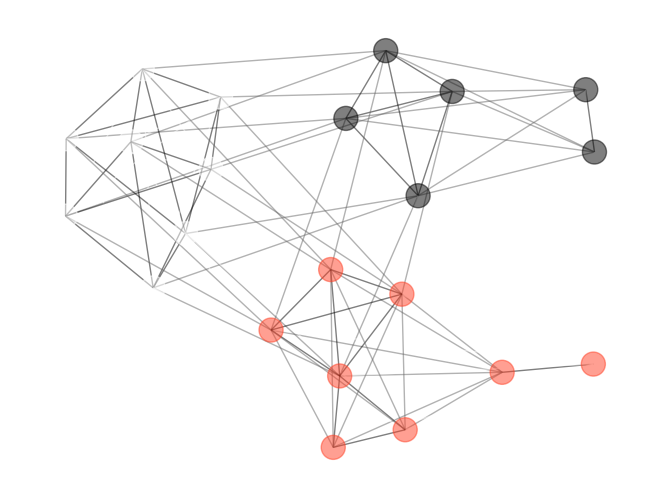

In [ ]:
HomNet.plot(0.5, Spec[1])

## RGT2 -> CBF5

In [ ]:
HomNet = HomotopyNet('RGT2', 'CBF5', GX, 5)
HomNet.size

0
100
finished network


161

/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


RGT2, BPT1, YOR1, PUF3, CBF5
RGT2, GPR1, RAS2, PHB1, AAC1, CBF5
RGT2, SNF3, HXT2, MUP1, PUF3, CBF5


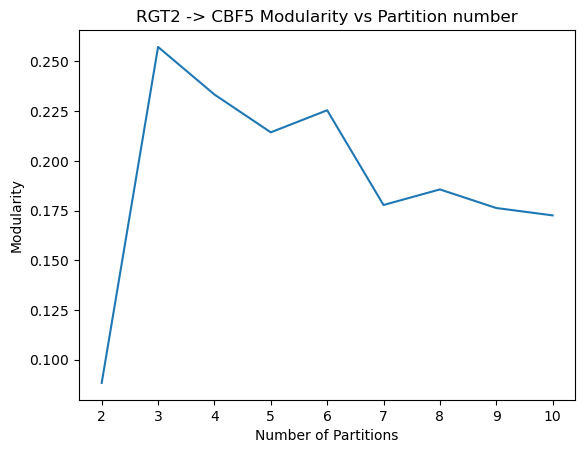

In [ ]:
k = HomNet.Spectral_Modularity_Plot()
Spec = HomNet.Spectral_Cluster(k)
path_to_proteins(HomNet.indices_to_pathname(Spec[0]))

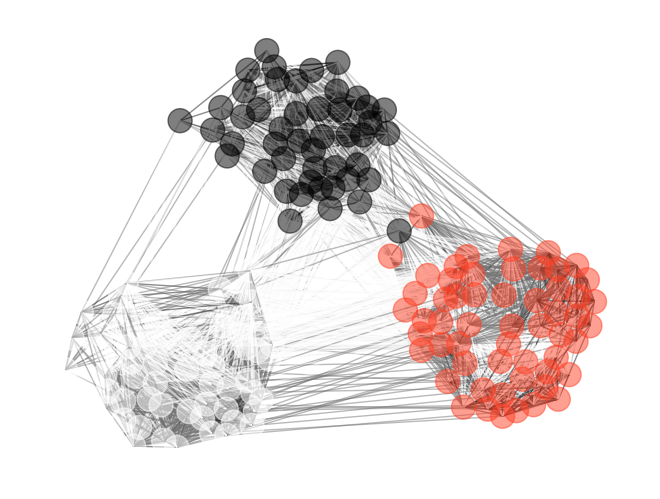

In [ ]:
HomNet.plot(0.5, Spec[1])